In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# data split and transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import pickle

In [365]:
# Load and inspect the dataset
data = 'Fish 2.csv'
fish_df = pd.read_csv(data)
print(fish_df.head(10))



  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
5   Bream   450.0     26.8     29.7     34.7  13.6024  4.9274
6   Bream   500.0     26.8     29.7     34.5  14.1795  5.2785
7   Bream   390.0     27.6     30.0     35.0  12.6700  4.6900
8   Bream   450.0     27.6     30.0     35.1  14.0049  4.8438
9   Bream   500.0     28.5     30.7     36.2  14.2266  4.9594


In [366]:
print(fish_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB
None


In [367]:
# Statistical summary
print(fish_df.describe())

            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean    398.326415   26.247170   28.415723   31.227044    8.970994    4.417486
std     357.978317    9.996441   10.716328   11.610246    4.286208    1.685804
min       0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     120.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%     273.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%     650.000000   32.700000   35.500000   39.650000   12.365900    5.584500
max    1650.000000   59.000000   63.400000   68.000000   18.957000    8.142000


In [368]:
null_= pd.DataFrame(fish_df.isna().sum())
null_

,0
Species,0
Weight,0
Length1,0
Length2,0
Length3,0
Height,0
Width,0


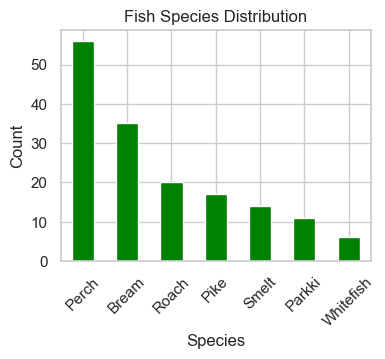

In [369]:
# Visualize distributions of numerical features

species_counts = fish_df['Species'].value_counts()

# Create a bar plot for the species distribution
plt.figure(figsize=(4, 3))

species_counts.plot(kind='bar', color='green')
plt.title('Fish Species Distribution')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [370]:
# checking for correlations
numerical_df = fish_df.select_dtypes(include=['float64', 'int64'])

corr = numerical_df.corr()
corr.style.background_gradient(cmap="ocean")

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.915712,0.918618,0.923044,0.724345,0.886507
Length1,0.915712,1.000000,0.999517,0.992031,0.625378,0.867050
Length2,0.918618,0.999517,1.000000,0.994103,0.640441,0.873547
Length3,0.923044,0.992031,0.994103,1.000000,0.703409,0.878520
Height,0.724345,0.625378,0.640441,0.703409,1.000000,0.792881
Width,0.886507,0.867050,0.873547,0.878520,0.792881,1.000000


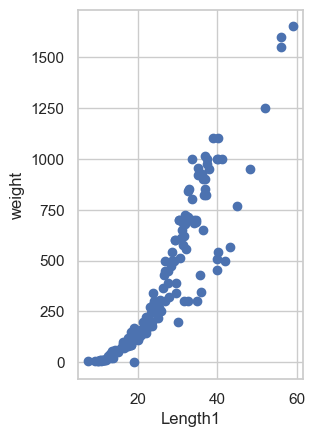

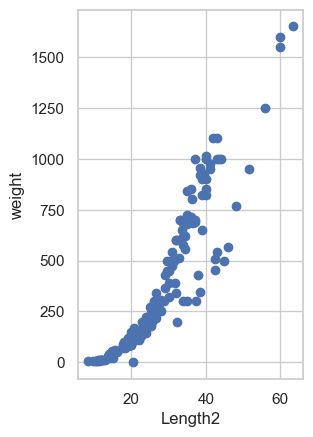

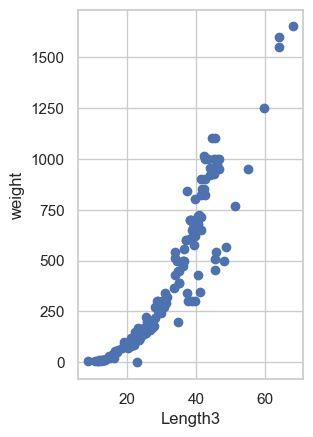

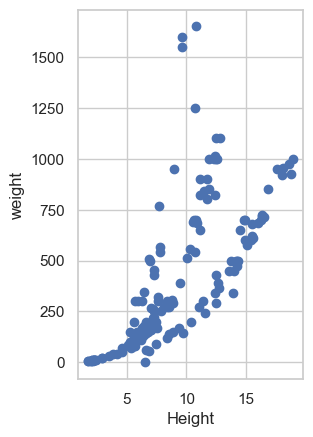

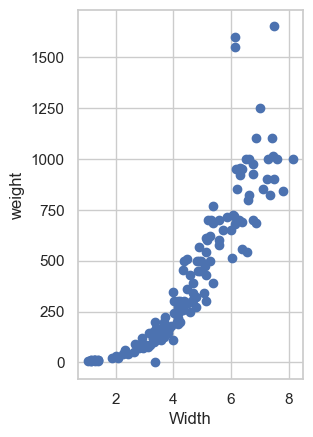

In [371]:
# checking for linear relationship between features and the target variable

numerical = ["Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:
    plt.subplot(1, 2, 1)
    plt.scatter(x=fish_df[feature], y=fish_df["Weight"])
    plt.xlabel(feature)
    plt.ylabel("weight")
    plt.show()

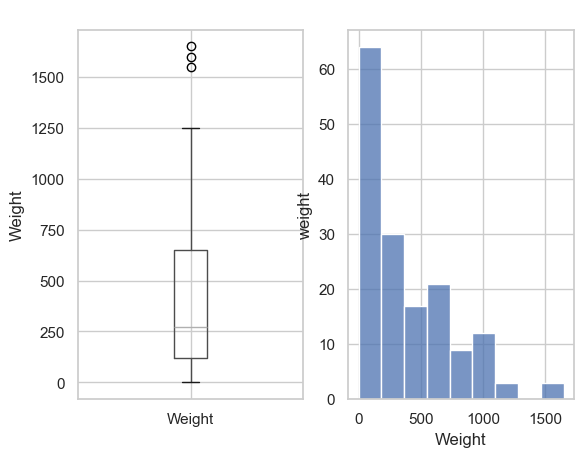

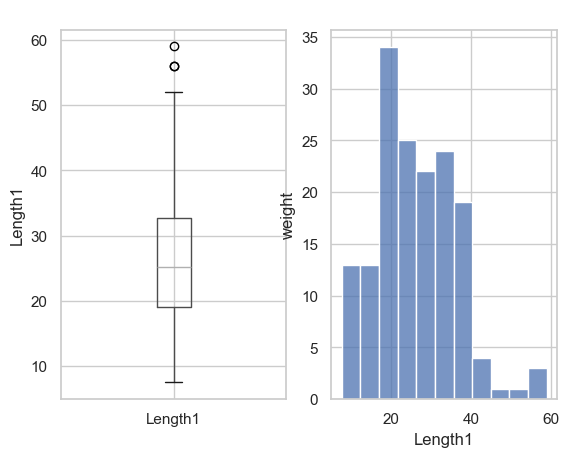

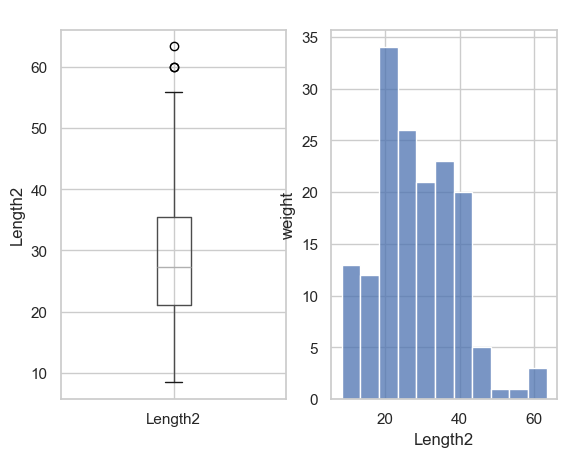

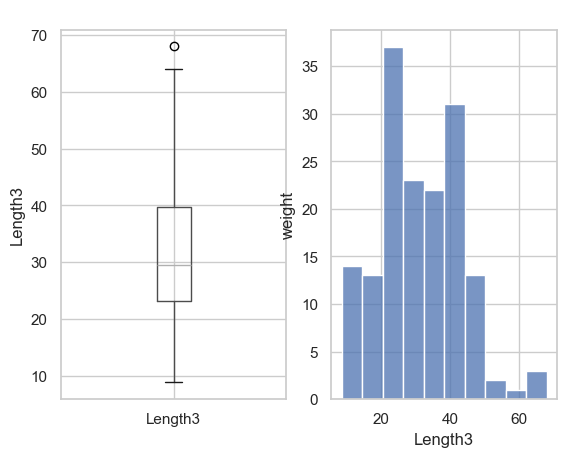

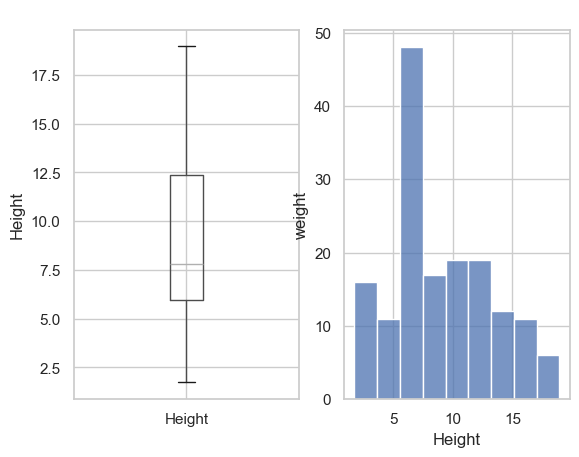

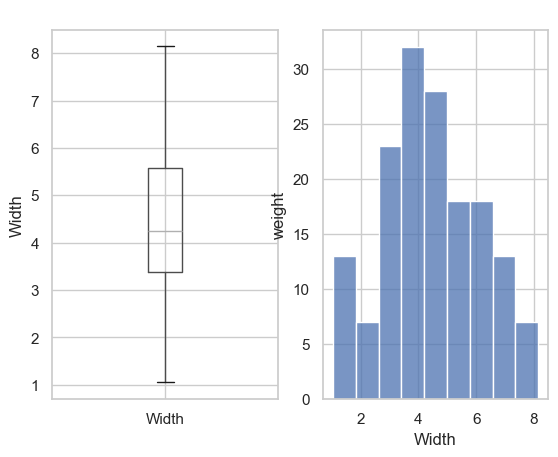

In [372]:
# checking for outliers and distribution

numerical = ["Weight", "Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:

    plt.subplot(1, 2, 1)
    fig = fish_df.boxplot(column=feature)
    fig.set_title(" ")
    fig.set_ylabel(feature)

    plt.subplot(1, 2, 2)
    fig = sns.histplot(fish_df[feature])
    fig.set_ylabel("weight")
    fig.set_xlabel(feature)

    plt.show()

In [373]:
# finding the outliers
for col in numerical:
    df = fish_df[col]
    df_Q1 = df.quantile(0.25)
    df_Q3 = df.quantile(0.75)
    df_IQR = df_Q3 - df_Q1
    df_lowerend = df_Q1 - (1.5 * df_IQR)
    df_upperend = df_Q3 + (1.5 * df_IQR)

    df_outliers = df[(df < df_lowerend) | (df > df_upperend)]
    print(df_outliers)

142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64
142    56.0
143    56.0
144    59.0
Name: Length1, dtype: float64
142    60.0
143    60.0
144    63.4
Name: Length2, dtype: float64
144    68.0
Name: Length3, dtype: float64
Series([], Name: Height, dtype: float64)
Series([], Name: Width, dtype: float64)


In [374]:
# dropping the outlier at row # 142
fish_data = fish_df.drop([142, 143, 144])

In [375]:
# checking for collinerity between the 3 length variables
fish_data[["Length1", "Length2", "Length3", "Weight"]].corr()

,Length1,Length2,Length3,Weight
Length1,1.000000,0.999418,0.990612,0.895743
Length2,0.999418,1.000000,0.993049,0.899759
Length3,0.990612,0.993049,1.000000,0.907292
Weight,0.895743,0.899759,0.907292,1.000000


In [376]:
fish_data[["Length1", "Length2", "Length3"]].head(10)

,Length1,Length2,Length3
0,23.2,25.4,30.0
1,24.0,26.3,31.2
2,23.9,26.5,31.1
3,26.3,29.0,33.5
4,26.5,29.0,34.0
5,26.8,29.7,34.7
6,26.8,29.7,34.5
7,27.6,30.0,35.0
8,27.6,30.0,35.1
9,28.5,30.7,36.2


In [377]:
fish_data = fish_data.drop(["Length1"], axis=1)

In [378]:
# Selecting features and target variable
X = fish_data.drop('Weight', axis=1)
y = fish_data['Weight']

# Defining numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['Species']  # Based on dataset inspection

# Creating preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols),
    ]
)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [379]:
# Building a pipeline with preprocessing and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Test MSE: {mse}")
print(f"Random Forest Test R^2 Score: {r2}")


Random Forest Test MSE: 2352.8877644374998
Random Forest Test R^2 Score: 0.9774925060124303


In [380]:
# Ensure all necessary imports are present

# Load the model
model = pickle.load(open('model.pkl', 'rb'))

# Sample input data in DataFrame format
data = {
    'Species': ['Bream'],  # Example species
    'Length1': [24],  # Vertical length in cm
    'Length2': [26.1],  # Diagonal length in cm
    'Length3': [31.2],  # Cross length in cm
    'Height': [12.4],  # Height in cm
    'Width': [4.3]  # Diagonal width in cm
}

# Convert the input data to a DataFrame
sample_df = pd.DataFrame(data)

# Making a prediction using the DataFrame with the loaded model
prediction = model.predict(sample_df)
print(f"Predicted Weight: {prediction[0]}")


Predicted Weight: 304.33
